In [418]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## Split the data into training and testing

To train the data, first need to split it into the data that the model will be trained on and the data the model will be assessed on. Here we are using median house value as the prediction of the model.

In [419]:
data = pd.read_csv("cleaned_housing.csv")
data.columns

Index(['Unnamed: 0', 'housing_median_age', 'median_income',
       'median_house_value', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN',
       'rooms_per_household', 'bedrooms_per_room', 'population_per_household',
       'coordinates'],
      dtype='object')

In [420]:
data.rename({"ocean_proximity_<1H OCEAN": "ocean_proximity_under_1H OCEAN"}, axis=1, inplace=True) # XGBoost model doesn't allow "<"
X = data.drop(["median_house_value", "Unnamed: 0"], axis=1, errors="ignore")
# Median house value removed as it is the answer the model will be tested on and Unnamed column appears with pandas usage
y = data["median_house_value"]

In [421]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14303, 11)
(6130, 11)
(14303,)
(6130,)


## Creating models

In [422]:
# Linear regression model:
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Forest regression model:
rf_model = RandomForestRegressor(n_estimators=10,random_state=10)
rf_model.fit(X_train, y_train)

# XGBoost model:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Testing models' accuracy

In [423]:
# Linear regression model:
y_lr_pred_test = reg_model.predict(X_test)
predictions = pd.DataFrame({"Actual": y_test, "Predicted": y_lr_pred_test, "Accuracy %": (y_pred_test/y_test) * 100})
print(predictions.sample(5))
print(f"Avrg accuracy %: {predictions['Accuracy %'].mean()}")
print(round(r2_score(y_test, y_lr_pred_test) * 100 , 2))

         Actual      Predicted  Accuracy %
6515   500001.0  355241.110557   71.048080
6504   241700.0  310940.250980  128.647187
7752   145800.0  224420.436631  153.923482
9463   107600.0  158287.682077  147.107511
13592  112500.0  100212.798706   89.078043
Avrg accuracy %: 112.00449874074421
61.02


In [424]:
# Forest regression model:
y_rf_pred_test = rf_model.predict(X_test)
predictions = pd.DataFrame({"Actual": y_test, "Predicted": y_rf_pred_test, "Accuracy %": (y_rf_pred_test/y_test) * 100})
print(predictions.sample(5))
print(f"Avrg accuracy %: {predictions['Accuracy %'].mean()}")
print(round(r2_score(y_test, y_rf_pred_test) * 100 , 2))

         Actual  Predicted  Accuracy %
17346  391300.0   366290.2   93.608536
11482  362400.0   291920.0   80.551876
11876  375000.0   184330.0   49.154667
19890  162500.0   219230.3  134.910954
11914  121100.0   134710.0  111.238646
Avrg accuracy %: 107.15371709241468
75.38


In [425]:
# XGBoost model:
y_xgb_pred_test = xgb_model.predict(X_test)
predictions = pd.DataFrame({"Actual": y_test, "Predicted": y_xgb_pred_test, "Accuracy %": (y_xgb_pred_test/y_test) * 100})
print(predictions.sample(5))
print(f"Avrg accuracy %: {predictions['Accuracy %'].mean()}")
print(round(r2_score(y_test, y_xgb_pred_test) * 100 , 2))

         Actual      Predicted  Accuracy %
14253  284900.0  294319.000000  103.306072
5610   276400.0  345676.906250  125.064004
9871   214500.0  159866.828125   74.529990
10180  263700.0  286124.968750  108.503970
3245   140600.0  133148.234375   94.700024
Avrg accuracy %: 106.79620574831326
78.17


## Important features
* The data that contributes the most to the predictions

Model can be built only using the most important features to simplify analysis of the predictions.

#### Forest regression model has a method feature importances which shows the most important features that are used by the model to calculate the prediction

<Axes: >

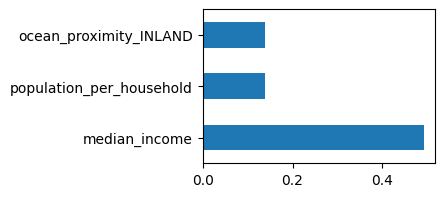

In [426]:
plt.figure(figsize=(3,2))
feat_importances = pd.Series(rf_model.feature_importances_, index = X_train.columns)
feat_importances.nlargest(3).plot(kind="barh") # plot 3 of the highest importance with side bar-plot

## Modifying model's parameters

In [427]:
# Current parameters which can be adjusted:
xgb_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [428]:
# Creating a second xgb model but with modified parameters this time:
xgb_model_2 = XGBRegressor(
    gamma=0.05,
    learning_rate=0.01,
    max_depth=6,
    n_estimators=1000,
    n_jobs=16,
    objective="reg:squarederror",
    subsample=0.8,
    scale_pos_weight=0,
    reg_alpha=0,
    reg_lambda=1,
    verbosity=1)

xgb_model_2.fit(X_train, y_train)
y_xgb_2_pred_test = xgb_model_2.predict(X_test)

In [429]:
predictions = pd.DataFrame({"Actual": y_test, "Predicted": y_xgb_2_pred_test, "Accuracy %": (y_xgb_2_pred_test/y_test) * 100})
print(predictions.sample(5))
print(f"Avrg accuracy %: {predictions['Accuracy %'].mean()}")
print(round(r2_score(y_test, y_rf_pred_test) * 100 , 2))

         Actual      Predicted  Accuracy %
5101    89800.0  107231.320312  119.411270
17227  129200.0  142461.468750  110.264295
3857   205100.0  200081.781250   97.553282
2946   245800.0  373053.406250  151.771117
12135  112500.0  108410.054688   96.364493
Avrg accuracy %: 107.31877442513836
75.38


## Saving and reusing a model

In [430]:
# Save the models to a file
models_to_save = {"linear_regression_model": reg_model, "forest_regression_model": rf_model,
                  "xgb_model": xgb_model, "xgb_model_2": xgb_model_2}
for model_name, model in models_to_save.items():
    with open(f"{model_name}.pkl", "wb") as model_file:
        pickle.dump(model, model_file)

In [431]:
# To use a model:
with open("xgb_model.pkl", "rb") as model_file:
    model = pickle.load(model_file)